<a href="https://colab.research.google.com/github/Gayatri-Priyadarsini/CS612_Assignment1/blob/main/Assignment1_Gayatri_21310015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

These are the available instructions on the simulator--

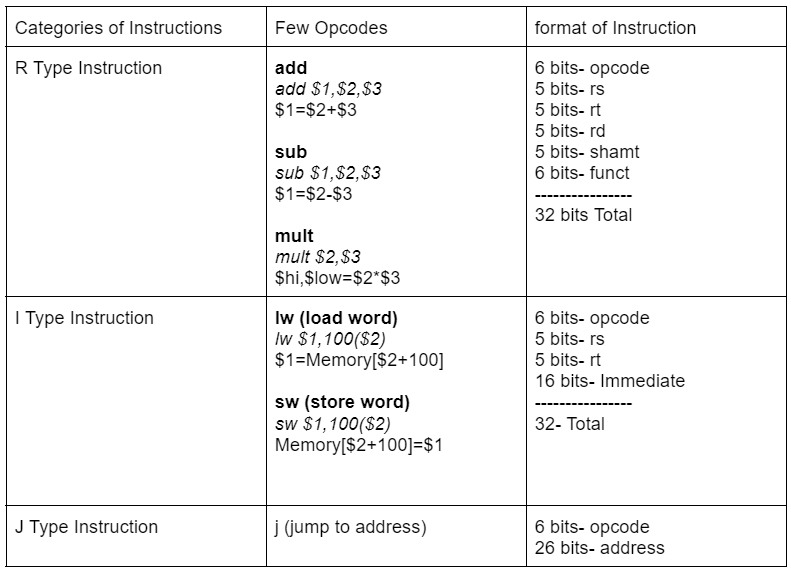

Enter the name of the input file with instructions written per line. 

For eg. : 

add $r1,$r2,$r3

sub $r4,$r1,$r5


In [135]:
filename=input("Please enter the file name and upload the file:")
from google.colab import files
uploaded = files.upload()
import collections 

Please enter the file name and upload the file:test.txt


Saving test.txt to test (3).txt


Instructions consist of the following fields--

* op --> operation
* rs --> Source register
* rt --> Transition register
* rd --> Destination register
* shamt --> Shift amount
* target --> Target address
* funct --> Function

Micro operations being used--

* aluop --> for performing the operations
* rr --> Reading from the register
* rw --> Writing to the register
* mr --> Reading from memory
* mw --> Writing to the memory


In [136]:
class Instruction(object):
    def __init__(self, **input):
        self.result = None
        
        self.sr1 = None 
        self.sr2 = None
        self.fields = {'op': None,'dest': None,'s1': None,'s2': None,'immed': None,'target': None}
        self.microops = {'aluop': None,'rr' : None,'rw': None,'rm' : None,'wm': None, }

        for key in input:
            if key in self.fields.keys():
                self.fields[key] = input[key]
            else:
                self.microops[key] = input[key]

    
        
class Nop(Instruction):
    pass
Nop = Nop()

class InstructionParser(object):
    def __init__(self):
        self.insSet=['add','sub','mult','lw','sw','j']   

    def file_parsing(self, filename):
        with open(filename) as f:
            data = filter((lambda x: x != '\n'), f.readlines())
            
            instructions = [self.parsing_individual_ins(a.replace(',',' ')) for a in data]
            return instructions

    def parsing_individual_ins(self, s):
        s = s.split()
        
        instr = s[0]
        
        if instr == 'add':
            return self.createADDins(s)
        elif instr == 'sub':
            return self.createSUBins(s)
        elif instr == 'mult':
            return self.createMULTins(s)
        elif instr == 'lw':
            return self.createMEMins(s)
        elif instr == 'sw':
            return self.createMEMins(s)
        elif instr == 'j':
            return self.createJins(s)
        else:
            return ParseError("Invalid Instruction")

    def createJins(self, s):
        if s[0] == "j":
            return Instruction(op=s[0],target=s[1])

    def createADDins(self,s):    
        return Instruction(op=s[0], dest=s[1], s1=s[2], s2=s[3], rr=1, rw=1, aluop=1)
    def createSUBins(self,s):    
        return Instruction(op=s[0], dest=s[1], s1=s[2], s2=s[3], rr=1, rw=1, aluop=1)
    def createMULins(self,s):    
        return Instruction(op=s[0], dest=s[1], s1=s[2], s2=s[3], rr=1, rw=1, aluop=1)


    def createMEMins(self, s):
        memread = s[0] == "lw" 
        memwrite = s[0] == "sw"
        if (memread or memwrite):
            import re 
            regex = re.compile("(\d+)\((\$r\d+)\)")
            match = regex.match(s[2])
            
            immedval = match.group(1) 
            sval = match.group(2)
            if s[0] == "lw" :
                return Instruction(op=s[0], dest = s[1], s1=sval, immed = immedval, rr = 1,rw = 1, aluop=1,  rm = 1)
            else :
                return Instruction(op=s[0],  s1 = s[1], s2=sval,immed = immedval, rr = 1, aluop=1, wm = 1)

    def createJTypeInstruction(self, s):
        return Instruction(op=s[0], target=s[1],rr= None)

class ParseError(Exception):
    def __init__(self, value):
        self.value = value
    


Arithmetic Operations: add, sub and mult

There are 5 stages in this pipeline:
* Fetch
* Register Write 
* Register Read
* Execute 
* Memory 

The pipeline is represented as an array holding different instructions at each clock cycle.

Main memory and the register($r0 to $r31 are represented using dictionaries)

step() works at each stage in the pipeline and takes the previous instruction's output as input and passes it to the processing() which executes the present instruction in the pipeline stage

forwarding() handles forwarding the values in the latches to the needed register value. 

There are inidividual functions for each stage which perform the micro-operations. 
  

In [139]:
class PipelineSimulator(object): 
    operations = {'add' : '+', 'sub' : '-', 'mult' : '*'} 
                  
    def __init__(self,instrCollection):
        self.instrCount = 0
        self.cycles = 0
        self.hazardList = []
        self.done = False
        self.stall = False
        self.forward=False
        self.forwardvalins=None
        self.forwardvalreg=None

        self.pipeline = [None for x in range(0,5)]

        self.pipeline[0] = FetchStage(Nop, self)
        self.pipeline[1] = RegWrite(Nop, self)
        self.pipeline[2] = RegRead(Nop, self)
        self.pipeline[3] = ExecStage(Nop, self)
        self.pipeline[4] = MemoryStage(Nop, self)
        
        self.registers = dict([("$r%s" % x, 0) for x in range(32)])


        # As there are no immediate operations, some registers can be initialised by default to see the working of the code. 
        #I have initialised 3 registers according the test cases

        self.registers['$r1']=100
        self.registers['$r3']=5 
        self.registers['$r5']=7

        self.mainmemory = dict([(x*4, 0) for x in range(0xffc//4)])

        self.programCounter = 0x1000

        self.instrCollection = instrCollection

        y=0
        for instr in self.instrCollection:
           self.mainmemory[0x1000 + y] = instr
           y += 4
    
    def step(self):
        self.cycles +=1

        self.pipeline[1] = RegWrite(self.pipeline[4].instr,self)
        if self.stall :
            self.pipeline[4] = MemoryStage(Nop,self)
            self.stall = False
        else :
            self.pipeline[4] = MemoryStage(self.pipeline[3].instr,self)
            self.pipeline[3] = ExecStage(self.pipeline[2].instr,self)
            self.pipeline[2] = RegRead(self.pipeline[0].instr,self)
            self.pipeline[0] = FetchStage(None, self)
        
        for pi in self.pipeline:
                pi.processing()
               

        if (self.pipeline[1].instr.microops['rw']) :
            self.hazardList.pop(0)
        
        self.checkDone()

        if self.stall:
            self.programCounter -= 4 
    
    def checkDone(self):
        self.done = True
        for pi in self.pipeline:
            if pi.instr is not Nop:
                self.done = False
    
    def run(self):
        
       
        self.regFile()
        print("\n<ProgramCounter>", self.programCounter)
        

        while not self.done:
            self.step()

        print("---------------------After processing:------------------------")
        print("--------------------------------------------------------------")
        
        self.regFile()
        print("\n<ProgramCounter>", self.programCounter)
        

    
    def forwarding(self, regName):

        if (self.pipeline[4] is not Nop 
                and self.pipeline[4].instr.result is not None
                and self.pipeline[4].instr.fields['dest'] == regName) :
                    print("---------------------------------------------------")
                    print("Forwarded from latch 4") 
                    latch=4
                    self.forward=True
                    
                    
                    return self.pipeline[4].instr.result
        elif (self.pipeline[1] is not Nop and self.pipeline[1].instr.fields['dest'] == regName ):
                    print("---------------------------------------------------")
                    print("Forwarded from latch 1")
                    latch=1
                    self.forward=True
                    
                    return self.pipeline[1].instr.result
        else :
            return "NO_HAZARD" 

    

    def regFile(self):

        print("\n Register File : ")
        for k,v in self.registers.items():
            print(k, " : " , v,'\t',end ="")
            

class PipelineStage(object):
    def __init__(self, instruction, simulator):
        self.instr = instruction
        self.simulator = simulator
        
    def processing(self):
        pass
    
    
    
class FetchStage(PipelineStage):
    def processing(self):
        
        if self.simulator.programCounter < (len(self.simulator.instrCollection) * 4 + 0x1000):
            self.simulator.instrCount += 1
            self.instr = self.simulator.mainmemory[self.simulator.programCounter]
        else:
            self.instr = Nop
        self.simulator.programCounter += 4
         
    
    
class RegRead(PipelineStage):
    def processing(self):
        if(self.instr.microops['rr']):
            self.instr.sr1 = self.simulator.registers[self.instr.fields['s1']]
            if (self.instr.fields['immed'] and not( self.instr.fields['op'] =='lw' or self.instr.fields['op'] =='sw')): 
                if "0x" in self.instr.fields['immed']:
                    self.instr.sr2 = int(self.instr.fields['immed'],16)
                else :
                    self.instr.sr2 = int(self.instr.fields['immed'])
            elif self.instr.fields['s2']:
                self.instr.sr2 = self.simulator.registers[self.instr.fields['s2']]
                    
        if self.instr.fields['op']== 'j':
            targetval = int(self.instr.fields['target'])
            self.simulator.programCounter = targetval
            self.simulator.pipeline[0] = FetchStage(Nop, self)

    
    
class ExecStage(PipelineStage):
    def processing(self):
        
        if self.instr is not Nop and self.instr.microops['aluop']:
            if self.instr.fields['s1'] in self.simulator.hazardList :
                
                forwardVal = self.simulator.forwarding(self.instr.fields['s1'])
                if forwardVal != "NO_HAZARD":
                    self.instr.sr1 = forwardVal
                    self.forwardvalins=self.instr.fields['op']
                    self.forwardvalreg=self.instr.fields['s1']
                    print("Forward at instruction: ", self.forwardvalins,"at the register",self.forwardvalreg)
                    print("---------------------------------------------------")
                else :
                    self.simulator.stall = True
                    return
            if self.instr.fields['s2'] in self.simulator.hazardList :
                forwardVal = self.simulator.forwarding(self.instr.fields['s2'])
                if forwardVal != "NO_HAZARD" :
                    self.instr.sr2 = forwardVal
                    self.forwardvalins=self.instr.fields['op']
                    self.forwardvalreg=self.instr.fields['s2']
                    print("Forward at instruction: ", self.forwardvalins,"at the register",self.forwardvalreg)
                    print("---------------------------------------------------")
                else :
                    self.simulator.stall = True
                    return

            if self.instr.microops['rw'] :
                self.simulator.hazardList.append(self.instr.fields['dest'])    
            if  self.instr.fields['op'] == 'lw':
                self.instr.sr1 = self.instr.sr1 + int(self.instr.fields['immed'])
            elif  self.instr.fields['op'] == 'sw':
                self.instr.sr2 = self.instr.sr2 + int(self.instr.fields['immed'])
            else :         
                self.instr.result = eval("%d %s %d" % (self.instr.sr1, self.simulator.operations[self.instr.fields['op']],self.instr.sr2))
                
    
    
class MemoryStage(PipelineStage):
    def processing(self):

        if self.instr.microops['wm']:
            self.simulator.mainmemory[self.instr.sr2] = self.instr.sr1
        elif self.instr.microops['rm']:
            self.instr.result = self.simulator.mainmemory[self.instr.sr1]
    
    
class RegWrite(PipelineStage):
    def processing(self):
        if self.instr.microops['rw']:
            self.simulator.registers[self.instr.fields['dest']] = self.instr.result
                
    


In [140]:
iparser = InstructionParser()
pipelinesim = PipelineSimulator(iparser.file_parsing(filename))

print("---------------------Before processing:------------------------")
print("--------------------------------------------------------------") 


for instr in pipelinesim.instrCollection:
    if (instr.fields['op']=='add' or  instr.fields['op']=='sub') or  (instr.fields['op']=='mult'):
        print(instr.fields['op'],' ',instr.fields['dest'],',',instr.fields['s1'],',',instr.fields['s2'])
    elif instr.fields['op']=='lw':
        print(instr.fields['op'],' ',instr.fields['dest'],',',instr.fields['s1'],',',instr.fields['immed'])
    elif instr.fields['op']=='sw':
        print(instr.fields['op'],' ',instr.fields['s1'],',',instr.fields['s2'],',',instr.fields['immed'])
    else:
        print(instr.fields['op'],' ',instr.fields['target'])

  
pipelinesim.run()



---------------------Before processing:------------------------
--------------------------------------------------------------
add   $r1 , $r2 , $r3
sub   $r4 , $r1 , $r5

 Register File : 
$r0  :  0 	$r1  :  100 	$r2  :  0 	$r3  :  5 	$r4  :  0 	$r5  :  7 	$r6  :  0 	$r7  :  0 	$r8  :  0 	$r9  :  0 	$r10  :  0 	$r11  :  0 	$r12  :  0 	$r13  :  0 	$r14  :  0 	$r15  :  0 	$r16  :  0 	$r17  :  0 	$r18  :  0 	$r19  :  0 	$r20  :  0 	$r21  :  0 	$r22  :  0 	$r23  :  0 	$r24  :  0 	$r25  :  0 	$r26  :  0 	$r27  :  0 	$r28  :  0 	$r29  :  0 	$r30  :  0 	$r31  :  0 	
<ProgramCounter> 4096
---------------------------------------------------
Forwarded from latch 4
Forward at instruction:  sub at the register $r1
---------------------------------------------------
---------------------After processing:------------------------
--------------------------------------------------------------

 Register File : 
$r0  :  0 	$r1  :  5 	$r2  :  0 	$r3  :  5 	$r4  :  -2 	$r5  :  7 	$r6  :  0 	$r7  :  0 	$